# Train a RNN network

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from nmp import plotter
from pathlib import Path
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import random
import copy

SAVE = 0
NOTES = '-' + 'lstm'

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
P2 = Path('S:\datasets')  # Dataset path

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor

# D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
D = "data/JSB Chorales"  # Dataset
# D = "data/MuseData"  # Dataset

LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# Complete 88-key keyboard
# LOW_LIM = 21  # A0
# HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

LOAD = 0
TRANS = 0

Using TensorFlow backend.


### Generate list of MIDI files

In [2]:
train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
validation_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]

# train_list = [train_list[x] for x in range(10)]
# validation_list = [validation_list[x] for x in range(5)]

print("\nTrain list:  ", train_list)
print("\nValidation list:  ", validation_list)


Train list:   ['10.mid', '100.mid', '103.mid', '104.mid', '106.mid', '108.mid', '109.mid', '11.mid', '110.mid', '117.mid', '118.mid', '119.mid', '12.mid', '123.mid', '124.mid', '125.mid', '126.mid', '127.mid', '128.mid', '13.mid', '130.mid', '134.mid', '135.mid', '137.mid', '139.mid', '140.mid', '141.mid', '142.mid', '144.mid', '145.mid', '146.mid', '148.mid', '150.mid', '154.mid', '156.mid', '158.mid', '159.mid', '16.mid', '160.mid', '161.mid', '162.mid', '163.mid', '164.mid', '165.mid', '168.mid', '17.mid', '171.mid', '172.mid', '173.mid', '174.mid', '175.mid', '177.mid', '179.mid', '18.mid', '185.mid', '186.mid', '19.mid', '190.mid', '193.mid', '195.mid', '196.mid', '197.mid', '198.mid', '2.mid', '200.mid', '205.mid', '206.mid', '207.mid', '21.mid', '212.mid', '215.mid', '217.mid', '218.mid', '219.mid', '22.mid', '220.mid', '222.mid', '223.mid', '224.mid', '226.mid', '228.mid', '229.mid', '23.mid', '232.mid', '233.mid', '234.mid', '236.mid', '237.mid', '238.mid', '239.mid', '241.mi

## Datasets

### Generate data from lists
Training, validation and test sets.

In [3]:
start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0, quant=Q)
validation = dataset.Dataset(validation_list, P / D / 'valid',  fs=FS, bl=0, quant=Q)

train.build_rnn_dataset("training", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_rnn_dataset("validation", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done")
print("Loading time: %.2f" % (end-start))

Building training dataset (229 files)
Building validation dataset (76 files)
Done
Loading time: 30.27


In [4]:
print(train.dataset[0].shape)
print(train.dataset[1].shape)
print(validation.dataset[0].shape)
print(validation.dataset[1].shape)
# print(test.dataset[0].shape)
# print(test.dataset[1].shape)

# pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Test target")
# plt.ylim(CROP)

(24711, 1280)
(24711, 1280)
(8276, 1280)
(8276, 1280)


In [5]:
seq_length = 100
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train.dataset[0]))
train_sequences = train_dataset.batch(seq_length, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((validation.dataset[0]))
valid_sequences = valid_dataset.batch(seq_length, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
# test_sequences = test_dataset.batch(10, drop_remainder=True)

train_dataset

<TensorSliceDataset shapes: (1280,), types: tf.bool>

In [6]:
def split_input_target(chunk):
    input_text = chunk[:, :10*64]
    target_text = chunk[:, 10*64:]
#     tf.reshape(target_text, shape=[100, 640])
#     input_text = chunk[:-1]
#     target_text = chunk[1:]
    return input_text, target_text

def split_input_target_base(chunk):
    input_text = chunk[:,:10]
    target_text = chunk[:,10:]
#     input_text = chunk[:-1]
#     target_text = chunk[:-1]
    return input_text, target_text

train_data = train_sequences.map(split_input_target)
valid_data = valid_sequences.map(split_input_target)
# test_data = test_sequences.map(split_input_target)
# baseline_data = test_sequences.map(split_input_target_base)

train_data

<MapDataset shapes: ((100, 640), (100, 640)), types: (tf.bool, tf.bool)>

In [4]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
valid_data = valid_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# test_data = test_data.batch(1, drop_remainder=True)
# baseline_data = baseline_data.batch(1, drop_remainder=True)
print("Train: ", train_data)
print("Valid: ", valid_data)
# print("Test: ", test_data)
# print("Baseline: ", baseline_data)

NameError: name 'train_data' is not defined

In [8]:
# for input_batch, label_batch in train_data.take(1):
#     print(input_batch.shape)
#     print(label_batch.shape)

### Save dataset

### Piano rolls of training dataset
Input and output piano rolls

In [9]:
# plt.rcParams["figure.figsize"] = (20, 8)
# pyplot_piano_roll(train.dataset[0][:, 0, :],
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train data")
# plt.ylim(CROP)
# pyplot_piano_roll(train.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train target")
# plt.ylim(CROP)

## Keras
### Build the model

In [5]:
BS = BATCH_SIZE  # Batch size
import importlib
importlib.reload(mod)
importlib.reload(dataset)
import time

In [6]:
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    model = mod.build_gru_model(NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy'])

model.summary()

now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (64, None, 128)           393728    
_________________________________________________________________
dense (Dense)                (64, None, 64)            8256      
_________________________________________________________________
Output (Dense)               (64, None, 640)           41600     
Total params: 443,584
Trainable params: 443,584
Non-trainable params: 0
_________________________________________________________________


### Try the model
Try the model before training

In [12]:
# for input_example_batch, target_example_batch in train_data.take(1):
#     example_batch_predictions = model(tf.cast(input_example_batch, tf.float32))
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

### Checkpoints

In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir = P / ('models/training_checkpoints/' + now.strftime("%Y%m%d-%H%M%S"))
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    period=5)

### Fit the model
Define batch size ```BS``` and number of ```epochs```

#### fit generator

In [14]:
# # Fit generator the model.
# BS = 64  # Batch size
# epochs = 20
# start = time.time()
# size_train = math.ceil(train.dataset[0].shape[0] / BS)
# spe_train = size_train
# size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# spe_valid = size_valid
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Fit generator. Data should be shuffled before fitting.
# history = model.fit(dataset.generate((train.dataset[0], train.dataset[1]), trans=1), epochs=epochs,
#           steps_per_epoch=spe_train,
#           validation_data=dataset.generate((validation.dataset[0], validation.dataset[1])),
#           validation_steps=spe_valid,
#           callbacks=[logger, csv_logger])

# end = time.time()

#### fit

In [15]:
# Fit the model.
BS = BATCH_SIZE  # Batch size
epochs = 500
start = time.time()

# Normal fit. Auto-shuffles data.
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, shuffle=True,
                    callbacks=[logger, csv_logger, checkpoint_callback])

end = time.time()

Train for 3 steps, validate for 1 steps
Epoch 1/500
3/3 [==============================] - 4s 1s/step - loss: 0.6860 - accuracy: 0.5595 - val_loss: 0.6655 - val_accuracy: 0.6470
Epoch 2/500
3/3 [==============================] - 0s 55ms/step - loss: 0.6454 - accuracy: 0.6863 - val_loss: 0.5951 - val_accuracy: 0.7570
Epoch 3/500
3/3 [==============================] - 0s 55ms/step - loss: 0.5624 - accuracy: 0.7854 - val_loss: 0.4937 - val_accuracy: 0.8372
Epoch 4/500
3/3 [==============================] - 0s 54ms/step - loss: 0.4582 - accuracy: 0.8558 - val_loss: 0.3869 - val_accuracy: 0.8854
Epoch 5/500
3/3 [==============================] - 0s 122ms/step - loss: 0.3570 - accuracy: 0.8935 - val_loss: 0.3001 - val_accuracy: 0.9142
Epoch 6/500
3/3 [==============================] - 0s 54ms/step - loss: 0.2838 - accuracy: 0.9175 - val_loss: 0.2519 - val_accuracy: 0.9249
Epoch 7/500
3/3 [==============================] - 0s 53ms/step - loss: 0.2468 - accuracy: 0.9255 - val_loss: 0.2318 - va

Epoch 59/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1938 - accuracy: 0.9269 - val_loss: 0.1900 - val_accuracy: 0.9282
Epoch 60/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1928 - accuracy: 0.9272 - val_loss: 0.1887 - val_accuracy: 0.9284
Epoch 61/500
3/3 [==============================] - 0s 56ms/step - loss: 0.1930 - accuracy: 0.9272 - val_loss: 0.1892 - val_accuracy: 0.9282
Epoch 62/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1925 - accuracy: 0.9270 - val_loss: 0.1875 - val_accuracy: 0.9282
Epoch 63/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1922 - accuracy: 0.9270 - val_loss: 0.1883 - val_accuracy: 0.9280
Epoch 64/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1915 - accuracy: 0.9270 - val_loss: 0.1874 - val_accuracy: 0.9278
Epoch 65/500
3/3 [==============================] - 0s 72ms/step - loss: 0.1899 - accuracy: 0.9274 - val_loss: 0.1880 - val_accuracy: 0.9278
Epoch 66/500


Epoch 117/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1752 - accuracy: 0.9279 - val_loss: 0.1726 - val_accuracy: 0.9288
Epoch 118/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1746 - accuracy: 0.9283 - val_loss: 0.1729 - val_accuracy: 0.9286
Epoch 119/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1755 - accuracy: 0.9279 - val_loss: 0.1716 - val_accuracy: 0.9286
Epoch 120/500
3/3 [==============================] - 0s 75ms/step - loss: 0.1747 - accuracy: 0.9281 - val_loss: 0.1712 - val_accuracy: 0.9287
Epoch 121/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1749 - accuracy: 0.9279 - val_loss: 0.1712 - val_accuracy: 0.9292
Epoch 122/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1741 - accuracy: 0.9281 - val_loss: 0.1712 - val_accuracy: 0.9292
Epoch 123/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1749 - accuracy: 0.9280 - val_loss: 0.1733 - val_accuracy: 0.9287
Epoch 

Epoch 175/500
3/3 [==============================] - 0s 84ms/step - loss: 0.1711 - accuracy: 0.9292 - val_loss: 0.1686 - val_accuracy: 0.9300
Epoch 176/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1699 - accuracy: 0.9294 - val_loss: 0.1677 - val_accuracy: 0.9305
Epoch 177/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1709 - accuracy: 0.9295 - val_loss: 0.1694 - val_accuracy: 0.9299
Epoch 178/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1706 - accuracy: 0.9295 - val_loss: 0.1680 - val_accuracy: 0.9305
Epoch 179/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1700 - accuracy: 0.9296 - val_loss: 0.1693 - val_accuracy: 0.9299
Epoch 180/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1703 - accuracy: 0.9296 - val_loss: 0.1673 - val_accuracy: 0.9304
Epoch 181/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1700 - accuracy: 0.9297 - val_loss: 0.1684 - val_accuracy: 0.9308
Epoch 

Epoch 233/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1671 - accuracy: 0.9306 - val_loss: 0.1657 - val_accuracy: 0.9314
Epoch 234/500
3/3 [==============================] - 0s 56ms/step - loss: 0.1662 - accuracy: 0.9308 - val_loss: 0.1653 - val_accuracy: 0.9314
Epoch 235/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1661 - accuracy: 0.9309 - val_loss: 0.1649 - val_accuracy: 0.9316
Epoch 236/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1662 - accuracy: 0.9307 - val_loss: 0.1651 - val_accuracy: 0.9315
Epoch 237/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1655 - accuracy: 0.9313 - val_loss: 0.1664 - val_accuracy: 0.9314
Epoch 238/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1650 - accuracy: 0.9311 - val_loss: 0.1657 - val_accuracy: 0.9312
Epoch 239/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1657 - accuracy: 0.9310 - val_loss: 0.1660 - val_accuracy: 0.9318
Epoch 

Epoch 291/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1617 - accuracy: 0.9325 - val_loss: 0.1635 - val_accuracy: 0.9325
Epoch 292/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1617 - accuracy: 0.9324 - val_loss: 0.1643 - val_accuracy: 0.9321
Epoch 293/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1611 - accuracy: 0.9327 - val_loss: 0.1654 - val_accuracy: 0.9319
Epoch 294/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1616 - accuracy: 0.9324 - val_loss: 0.1647 - val_accuracy: 0.9324
Epoch 295/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1612 - accuracy: 0.9327 - val_loss: 0.1638 - val_accuracy: 0.9327
Epoch 296/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1618 - accuracy: 0.9324 - val_loss: 0.1631 - val_accuracy: 0.9326
Epoch 297/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1609 - accuracy: 0.9326 - val_loss: 0.1628 - val_accuracy: 0.9328
Epoch 

Epoch 349/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1575 - accuracy: 0.9341 - val_loss: 0.1636 - val_accuracy: 0.9327
Epoch 350/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1584 - accuracy: 0.9338 - val_loss: 0.1625 - val_accuracy: 0.9334
Epoch 351/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1576 - accuracy: 0.9341 - val_loss: 0.1620 - val_accuracy: 0.9332
Epoch 352/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1580 - accuracy: 0.9339 - val_loss: 0.1621 - val_accuracy: 0.9334
Epoch 353/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1572 - accuracy: 0.9342 - val_loss: 0.1615 - val_accuracy: 0.9335
Epoch 354/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1574 - accuracy: 0.9342 - val_loss: 0.1608 - val_accuracy: 0.9337
Epoch 355/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1569 - accuracy: 0.9343 - val_loss: 0.1608 - val_accuracy: 0.9336
Epoch 

Epoch 407/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1535 - accuracy: 0.9357 - val_loss: 0.1606 - val_accuracy: 0.9340
Epoch 408/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1531 - accuracy: 0.9358 - val_loss: 0.1609 - val_accuracy: 0.9341
Epoch 409/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1528 - accuracy: 0.9361 - val_loss: 0.1618 - val_accuracy: 0.9338
Epoch 410/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1528 - accuracy: 0.9359 - val_loss: 0.1604 - val_accuracy: 0.9339
Epoch 411/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1526 - accuracy: 0.9361 - val_loss: 0.1604 - val_accuracy: 0.9340
Epoch 412/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1533 - accuracy: 0.9357 - val_loss: 0.1614 - val_accuracy: 0.9339
Epoch 413/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1524 - accuracy: 0.9362 - val_loss: 0.1617 - val_accuracy: 0.9336
Epoch 

Epoch 465/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1491 - accuracy: 0.9372 - val_loss: 0.1600 - val_accuracy: 0.9344
Epoch 466/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1493 - accuracy: 0.9372 - val_loss: 0.1612 - val_accuracy: 0.9339
Epoch 467/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1504 - accuracy: 0.9369 - val_loss: 0.1623 - val_accuracy: 0.9335
Epoch 468/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1498 - accuracy: 0.9372 - val_loss: 0.1613 - val_accuracy: 0.9341
Epoch 469/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1499 - accuracy: 0.9371 - val_loss: 0.1619 - val_accuracy: 0.9338
Epoch 470/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1489 - accuracy: 0.9374 - val_loss: 0.1617 - val_accuracy: 0.9337
Epoch 471/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1497 - accuracy: 0.9372 - val_loss: 0.1604 - val_accuracy: 0.9344
Epoch 

In [16]:
('rnn-' + D[5:] + '-loss-train.dat').lower()

'rnn-jsb chorales-loss-train.dat'

### History

In [17]:
print("\nTraining time: ", (end-start), "\n")
hist = pd.DataFrame(history.history)

if SAVE:
    hist['loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-train' + NOTES + '.dat').lower(), sep=' ', header=None)
    hist['val_loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-valid' + NOTES + '.dat').lower(), sep=' ', header=None)

hist


Training time:  88.14602470397949 



,loss,accuracy,val_loss,val_accuracy
0,0.686047,0.559462,0.665545,0.646973
1,0.645436,0.686327,0.595142,0.756997
2,0.562399,0.785387,0.493679,0.837220
3,0.458240,0.855800,0.386939,0.885424
4,0.357042,0.893500,0.300104,0.914198
...,...,...,...,...
495,0.148188,0.937722,0.159562,0.934439
496,0.149021,0.937500,0.161925,0.933916
497,0.148098,0.937766,0.160704,0.934158
498,0.147881,0.937731,0.161061,0.933897


### Plot loss function of training and validation sets

Training time:  88.14602470397949


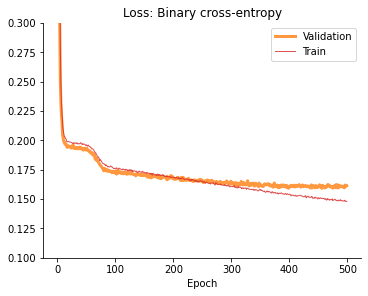

In [18]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))
plt.plot(hist['val_loss'], '-', lw=3, c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.plot(hist['loss'], '-', lw=1, c='tab:red', label='Train', ms=8, alpha=0.8)
plt.xlabel('Epoch')
# plt.xticks(range(epochs))
plt.legend()
plt.title('Loss: Binary cross-entropy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0.1, 0.3])
# fig.savefig(PLOTS / 'compare-lstm-loss.eps', fmt='eps')
print("Training time: ", (end-start))

## Save model to file
Model can be loaded with:
``` python
load_model(filepath=str(folder_path), compile=True)
```

In [19]:
# model.save(str(P / 'models' / 'simpleRNN-nottingham-3') + '.h5', save_format='h5')
# model.save(str(P / 'models' / 'lstm-z-de') + '.h5', save_format='h5')

### Model evaluation

In [20]:
print("Evaluation on train set:")
e_train = model.evaluate(train_data)

print("\nEvaluation on validation set:")
e_valid = model.evaluate(valid_data)

# print("\nEvaluation on test set:")
# e_test = model.evaluate(test_data)

results = {out: e_train[i] for i, out in enumerate(model.metrics_names)}
res = pd.DataFrame(list(results.items()), columns=['metric', 'train'])
res = res.set_index('metric')

results2 = {out: e_valid[i] for i, out in enumerate(model.metrics_names)}
res2 = pd.DataFrame(list(results2.items()), columns=['metric', 'validation'])
res2 = res2.set_index('metric')

# results3 = {out: e_test[i] for i, out in enumerate(model.metrics_names)}
# res3 = pd.DataFrame(list(results3.items()), columns=['metric', 'test'])
# res3 = res3.set_index('metric')
res3 = pd.DataFrame([])

result = pd.concat([res, res2, res3], axis=1, sort=False)
result

Evaluation on train set:
3/3 [==============================] - 0s 28ms/step - loss: 0.1479 - accuracy: 0.9378

Evaluation on validation set:
1/1 [==============================] - 0s 31ms/step - loss: 0.1617 - accuracy: 0.9337


,train,validation
metric,,
loss,0.147877,0.161699
accuracy,0.937803,0.933750


## Make predictions
Predictions from test dataset

### Restore last checkpoint

Build again the model and restore the checkpoint with weights to use a different batch size for test.

In [21]:
model = mod.build_gru_model(NUM_NOTES, 1)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy'])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


In [22]:
test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# test_list = [test_list[x] for x in range(3)]
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
test.build_rnn_dataset("test", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.dataset[0].shape

Building test dataset (77 files)


(8503, 1280)

In [23]:
test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
test_sequences = test_dataset.batch(50, drop_remainder=True)
test_data = test_sequences.map(split_input_target)
test_data = test_data.batch(1, drop_remainder=True)

In [24]:
# predictions = model.predict(test_data)

In [25]:
# predictions_bin = dataset.ranked_threshold(predictions[:, 0, :NUM_NOTES], 1, 3)

In [26]:
# pyplot_piano_roll(predictions_bin, low_lim=LOW_LIM, high_lim=HIGH_LIM)

## Load tests dataset (standard way)

In [27]:
# importlib.reload(dataset)
# st = 10  # Past timesteps
# num_ts = 10  # Predicted timesteps

# test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# # test_list = test_list[:20]
# test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
# test.build_dataset("test", step=st, t_step=num_ts, steps=st,
#                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [28]:
# print(test.dataset[0].shape)
# pyplot_piano_roll(test.dataset[0][:, 0, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [29]:
# reshaped = test.dataset[0].reshape(len(test.dataset[0]), 640)
# reshaped.shape

### Make predictions

In [30]:
# import importlib
# importlib.reload(dataset)

# rnn_predictions = []
# for c, t in enumerate(reshaped):
#     rnn_predictions.append(dataset.predict_rnn(t, model))
#     if c % 1000 == 0:
#         print("Processed timestep %d" % c)
# #     pyplot_piano_roll(predi, low_lim=LOW_LIM, high_lim=HIGH_LIM)
# #     pyplot_piano_roll(t, low_lim=LOW_LIM, high_lim=HIGH_LIM)
# #     break

# rnn_predictions = np.array(rnn_predictions)

In [31]:
# pyplot_piano_roll(rnn_predictions[:, 1, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

### Evaluate AUC-ROC
Reshape predictions

In [32]:
# predictions = rnn_predictions.reshape([len(rnn_predictions), 640])


In [33]:
# # Build baseline
# L = test.dataset[0].shape[0]
# baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
# baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
#                        down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)

# pred_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], predictions, NUM_NOTES)
# base_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], baseline.dataset[1][:L, :], NUM_NOTES)

In [34]:
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 8),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (prediction)')
# g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (baseline)')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat.eps', format='eps')
# print(pred_auc.shape)

In [35]:
# c1 = 0
# c2 = 64
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 6),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (crop) [prediction]')
# g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (crop) [baseline]')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
# print(pred_auc.shape)

In [36]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

# ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
# ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

# ax.set_ylim([0.4, 1])
# ax.set_ylim([0.4, 1])
# ax.legend()
# plt.title('Avg. AUC-ROC per predicted timestep')
# plt.xlabel('Timestep')
# # plt.xticks([0, 2, 4, 6, 8, 10])
# plt.ylabel('ROC AUC')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# name = 'auc' + str()
# plt.grid()
# # plt.savefig(PLOTS / 'rnn10.eps', format='eps')

# print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
# print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [37]:
# np.mean(pred_auc[c1:c2])

In [38]:
# np.mean(base_auc[c1:c2])

# Other 

In [39]:
model.reset_states()
predauc = []
baseauc = []

merged_input = []
merged_output = []
merged_pred = []

for input_batch, label_batch in test_data.take(-1):
    predictions = model(tf.cast(input_batch, tf.float32))

    pred = np.array(tf.squeeze(predictions, 0))
    inp = np.array(tf.squeeze(input_batch, 0))
    out = np.array(tf.squeeze(label_batch, 0))

    # Merged piano rolls to compute overall AUC.
    merged_input.append(inp)
    merged_output.append(out)
    merged_pred.append(pred)

merged_input = np.concatenate([x for x in merged_input])
merged_output = np.concatenate([x for x in merged_output])
merged_pred = np.concatenate([x for x in merged_pred])

# merged_input = merged_input.reshape((len(merged_input), 10, 64))
# merged_output = merged_output.reshape((len(merged_output), 10, 64))
# merged_pred = merged_pred.reshape((len(merged_pred), 10, 64))

print(merged_input.shape)

baseline = copy.deepcopy(merged_input)
for t in range(len(merged_input)):
    for s in range(10):
        baseline[t, 64*s:64*(s+1)] = merged_input[t, 640-64:640]

pred_auc = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
base_auc = ev_metrics.compute_auc(merged_output, baseline, NUM_NOTES)

# print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))


# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# plt.rcParams["figure.figsize"] = (13, 4)
# pyplot_piano_roll(merged_output,
#                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Target (labels)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
#                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Predictions")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# pyplot_piano_roll(merged_input[:, :NUM_NOTES],
#                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Baseline (equal to inputs)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


(8500, 640)


(64, 10)


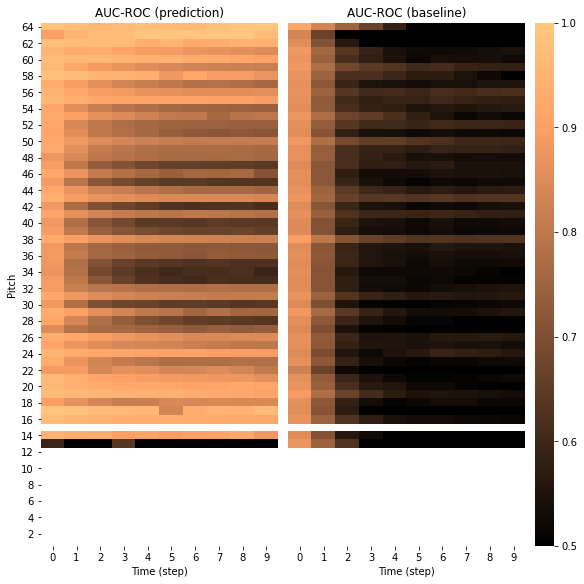

In [40]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

(64, 10)


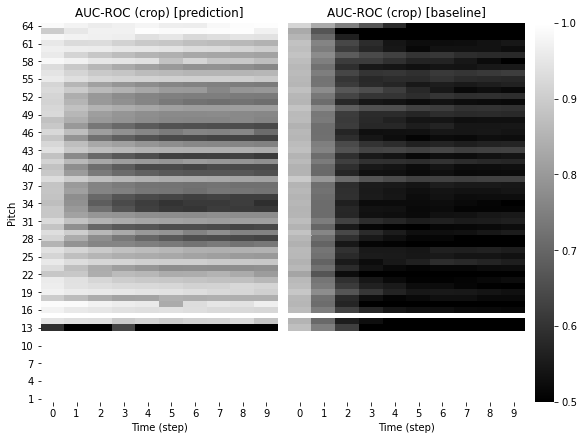

In [41]:
c1 = 0
c2 = 64
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

Predict. mean value: 0.8131267041936336
Baseline mean value: 0.6021980503722528


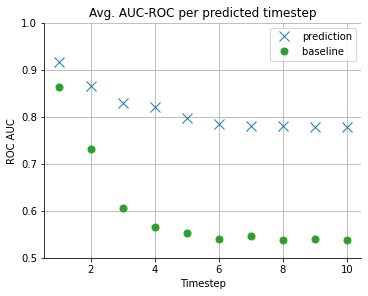

In [42]:
num_ts = 10
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'compare-lstm-auc.eps', format='eps')

print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [43]:
if SAVE:
    auc_df = pd.DataFrame(
        {'pred': np.mean(pred_auc[c1:c2]),
         'base': np.mean(base_auc[c1:c2])})
    auc_df['pred'].to_csv(('tables/rnn-' + D[5:] + '-auc-pred' + NOTES + '.dat').lower(), sep=' ', header=None)
    auc_df['base'].to_csv(('tables/rnn-' + D[5:] + '-auc-base' + NOTES + '.dat').lower(), sep=' ', header=None)

In [44]:
# inp = []
# lab = []
# cnt = 0
# print(test_data)
# for input_batch, label_batch in test_data.take(100):
#     print(input_batch.shape)
#     inp.append(np.array(tf.squeeze(input_batch, 0)))
#     lab.append(np.array(tf.squeeze(label_batch, 0)))
# inp = np.array(inp)
# print(inp.shape)
# pyplot_piano_roll(inp[:, 0, :], cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [45]:
# def generate_data(model, input_batch, size):
#     generated = []
# #     print(input_batch.shape)
#     for i in range(size):
# #         print(input_batch.shape)
#         predictions = model(tf.cast(input_batch, tf.float32))
#         pred = np.array(tf.squeeze(predictions, 0))
#         predictions_bin = dataset.ranked_threshold(pred, steps=1, how_many=5)

#         generated.append(np.array(predictions_bin[-1]))
#         input_batch = tf.expand_dims([predictions_bin[-1]], 0)
#     return np.array(generated)

In [46]:
# model.reset_states()
# predauc = []
# baseauc = []

# merged_input = []
# merged_output = []
# merged_pred = []

# size = 10
# import time


# predizioni = []
# a = 0
# for input_batch, label_batch in test_data.take(-1):
# #     print(input_batch.shape)
# #     time.sleep(50)
# #     print(a)
#     a += 1

#     generated = generate_data(model, input_batch, size)

#     predizioni.append(generated)
# #     print("OK")
# #     inp = np.array(tf.squeeze(input_batch, 0))
# #     out = np.array(tf.squeeze(label_batch, 0))

# #     pyplot_piano_roll(out,
# #                       cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# #     plt.title("Target")
# #     plt.savefig(PLOTS / "roll1.png")

# #     pyplot_piano_roll(pred,
# #                       cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# #     plt.title("Predictions")
# #     plt.savefig(PLOTS / "roll.png")

# #     pyplot_piano_roll(inp,
# #                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# #     plt.title("Baseline (repetition of the input)")
# #     plt.savefig(PLOTS / "roll3.png")

# #     pred_auc = ev_metrics.compute_auc(out, pred, NUM_NOTES)
# #     base_auc = ev_metrics.compute_auc(out, inp, NUM_NOTES)
# #     predauc.append(np.mean(np.mean(pred_auc)))
# #     baseauc.append(np.mean(np.mean(base_auc)))

    
#     # Merged piano rolls to compute overall AUC.
# #     merged_input.append(inp)
# #     merged_output.append(out)
# #     merged_pred.append(pred)

# # merged_input = np.concatenate([x for x in merged_input])
# # merged_output = np.concatenate([x for x in merged_output])
# # merged_pred = np.concatenate([x for x in merged_pred])

# # pred_auc_merged = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
# # base_auc_merged = ev_metrics.compute_auc(merged_output, merged_input, NUM_NOTES)

# # print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# # print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# # print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# # print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))

# predizioni = np.array(predizioni)
# print(predizioni.shape)

# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# # plt.rcParams["figure.figsize"] = (13, 4)
# # pyplot_piano_roll(merged_output,
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Target (labels)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# # pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
# #                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Predictions")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# # pyplot_piano_roll(merged_input[:, :NUM_NOTES],
# #                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Baseline (equal to inputs)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


In [47]:
# for i in range(10):
#     pyplot_piano_roll(predizioni[:, i, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)